# PDE-FIND for Burger's Equation

Samuel Rudy, 2016

This notebook demonstrates PDE-FIND on Burger's equation with an added diffusive term.
$$
u_t + uu_x = 0.1u_{xx}
$$
The solution given is a single travelling wave, starting out as a Gaussian.

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)
import warnings; warnings.filterwarnings("ignore")

import numpy as np
from numpy.random import default_rng
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

import sys; sys.path.append('../')
from PDE_FIND import *

import sys; sys.path.append('../../parametric-discovery/')
from best_subset import *
from frols import frols
from p_linear_regression import PLinearRegression
from r_pca import R_pca
from pde_diff_new import RPCA
from RobustPCA.rpca import RobustPCA

import scipy.io as sio
from scipy.signal import savgol_filter
import itertools

from sklearn.preprocessing import normalize
from sklearn.linear_model import Ridge, BayesianRidge, LinearRegression as SkLinearRegression
from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from abess.linear import LinearRegression
from bess import PdasLm
import pysindy as ps

from os.path import join as join_path
FIGURE_EXPORT_PATH = "/Users/pongpisit/Documents/figure_export/"

# from rad import AnomalyDetection_RPCA

def evaluate_coefficients(prediected_coeffs):
    GROUND = np.array([0.1, -1])
    errs = 100*np.abs(GROUND-np.array(prediected_coeffs).flatten())/np.abs(GROUND)
    return errs.mean(), errs.std()

import torch, sympytorch
import torch.nn as nn
import torch.nn.functional as F
from sympy import symbols, simplify, lambdify
from mathparser import math_eval
from varname import nameof
from misc import h5file

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = sio.loadmat('../Datasets/burgers.mat')
u = (data['usol']).real
x = (data['x'][0]).real
t = (data['t'][:,0]).real
dt = t[1]-t[0]
dx = x[2]-x[1]
X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T

cmap = viridis


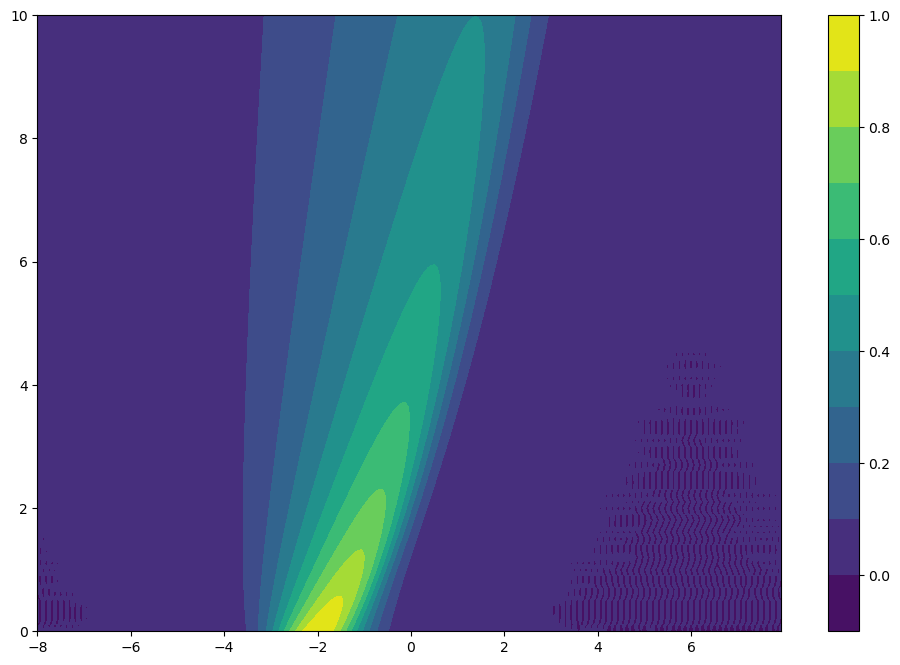

In [3]:
from matplotlib import cm
cmap_name = cm.get_cmap().name
print("cmap =", cmap_name)

plt.contourf(X, T, u.T, levels=10, cmap=cmap_name)
plt.colorbar()
plt.show()

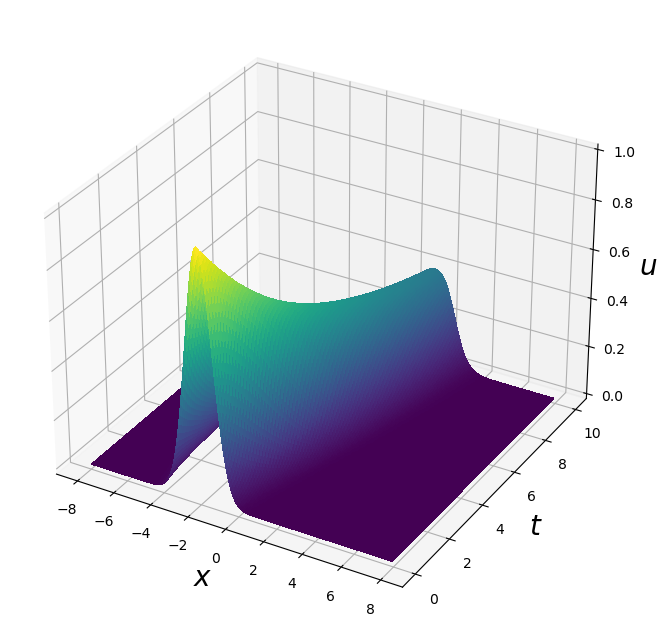

In [4]:
fig = figure()
ax = fig.gca(projection='3d')
ax.set_zlabel("$u$", fontsize=20)
ax.set_xlabel("$x$", fontsize=20)
ax.set_ylabel("$t$", fontsize=20)
surf = ax.plot_surface(X, T, u.T, 
                       rstride=1, cstride=1, cmap=cmap_name, 
                       linewidth=1, antialiased=False)
# plt.title("Burgers' PDE", fontsize=20)
# plt.savefig(fname=join_path(FIGURE_EXPORT_PATH, "burgers3d.png"), dpi=300)
plt.show()

In [5]:
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatial_grid=x,
    is_uniform=True,
)

print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=0.1, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(np.expand_dims(u, -1), t=dt)
model.print()

STLSQ model: 
(x0)' = 0.100 x0_11 + -1.001 x0x0_1


## Construct $\Theta (U)$ and compute $U_t$

The function build_linear_system does this for us.  We specify <br>
D = highest derivative to appear in $\Theta$  <br>
P = highest degree polynomial of $u$ to appear in $\Theta$ (not including multiplication by a derivative.  <br>
time_diff and space_diff taken via finite differences

Printed out is a list of candidate functions for the PDE.  Each is a column of $\Theta (U)$

In [6]:
Ut, R, rhs_des = build_linear_system(u, dt, dx, D=3, P=3, time_diff = 'FD', space_diff = 'FD')
rhs_des = rhs_des[1:]
R = R[:, 1:].real; Ut = Ut.real

## Solve for $\xi$

TrainSTRidge splits the data up into 80% for training and 20% for validation.  It searches over various tolerances in the STRidge algorithm and finds the one with the best performance on the validation set, including an $\ell^0$ penalty for $\xi$ in the loss function.

In [7]:
# Solve with STRidge
w = TrainSTRidge(R,Ut,10**-5,0.1)
print("PDE derived using STRidge")
print_pde(w, rhs_des)

l0_penalty: 1.6123253173828125
PDE derived using STRidge
u_t = (-1.000403 +0.000000i)uu_{x}
    + (0.100145 +0.000000i)u_{xx}
   


## Now identify the same dynamics but with added noise.

The only difference from above is that finite differences work poorly for noisy data so here we use polynomial interpolation.  With deg_x or deg_t and width_x or width_t we specify the degree number of points used to fit the polynomials used for differentiating x or t.  Unfortunately, the result can be sensitive to these.

In [8]:
# K = 2000 experiments
# weak lib only can tolerate up to 75 (maybe more?)
# weak lib + KalmanDiff: 90 (maybe more?)
# weak lib + KalmanDiff + Robust PCA: 110
# set np.random.seed(0) to reproduce...
np.random.seed(0)
noise_lv = float(40)
noise = 0.01*np.abs(noise_lv)*(u.std())*np.random.randn(u.shape[0],u.shape[1])
un = u + noise
np.mean(noise), np.std(noise), np.max(noise), np.min(noise)

(-0.00017436017271128736,
 0.07192089134552937,
 0.2780377297273821,
 -0.32265115805438993)

In [9]:
Utn, Rn, rhs_des = build_linear_system(un, dt, dx, D=3, P=3, time_diff = 'poly',
                                       deg_x = 4, deg_t = 4, 
                                       width_x = 10, width_t = 10)
rhs_des = rhs_des[1:]
Rn = Rn[:, 1:].real; Utn = Utn.real

In [10]:
# Solve with STRidge
w = TrainSTRidge(Rn,Utn,10**-5,1)
print("PDE derived using STRidge")
print_pde(w, rhs_des)

l0_penalty: 1.958869140625
PDE derived using STRidge
u_t = (-0.709884 +0.000000i)uu_{x}
   


In [11]:
## Goals: implement my own optimizer and differentiation_method class!
from functools import partial
import derivative
from tvregdiff import TVRegDiff, tvregdiff, numdiff, pysindydiff, savgol_denoise
# import sys; sys.path.insert(0, "../../derivative/"); import derivative
class KalmanDiff(ps.BaseDifferentiation):
    def __init__(self, alpha, poly_deg=None, rpca_lambda=None, d=1, axis=1, is_uniform=True, periodic=False):
        super(KalmanDiff, self).__init__()
        # Kalman diff
        self.alpha = alpha
        self.diff_func = derivative.Kalman(alpha=self.alpha)
        self.d = d
        self.diff = partial(pysindydiff, **{"diff_method":self.diff_func, "order":self.d})
        # Savgol denoising
        self.poly_deg = poly_deg
        if poly_deg is not None:
            if poly_deg%2 == 0: window_length = self.poly_deg + 1
            else: window_length = self.poly_deg + 2
            self.denoise = partial(savgol_denoise, **{"window_length":window_length, "poly_deg":self.poly_deg})
        else:
            self.denoise = lambda _: _
        # Robust PCA
        self.rpca_lambda = rpca_lambda
        # Other info...
        self.axis = axis
        self.is_uniform = is_uniform
        self.periodic = periodic
        # data transformation
        # rs = np.ones(2).astype(np.int32); rs[self.axis] = -1; rs = tuple(rs)
        self.transform = np.vectorize(composite_function(self.diff, self.denoise, left2right=True), signature="(m),(m)->(m)")
    # _differentiate
    def _differentiate(self, x, t):
        in_shape = x.shape
        if len(in_shape) == 2: x = np.expand_dims(x, -1) # x should now be 3-dimensional
        if isinstance(t, float) and self.is_uniform: 
            t = np.linspace(0, stop=t*(x.shape[self.axis]-1), num=x.shape[self.axis])
        out = []
        # wrt to x var
        if self.axis == 0:
            for i in range(x.shape[-1]):
                # use lambda and partial from functools to help shorten the code
                # diff = np.hstack([self.denoise(self.diff(x[:, j:j+1, i], t)).reshape(-1, 1) 
                #                   for j in range(x.shape[1])])
                # diff = np.hstack([self.transform(x[:, j:j+1, i], t) for j in range(x.shape[1])])
                # diff = np.vectorize(self.transform, signature="(m),(m)->(m)")(x[:,:,i].T, t).T
                diff = self.transform(x[:,:,i].T, t).T
                if self.rpca_lambda is not None:
                    diff = self._get_low_rank(diff)
                out.append(np.expand_dims(diff, axis=-1))
        # wrt to time var
        elif self.axis == 1:
            for i in range(x.shape[-1]):
                # use lambda and partial from functools to help shorten the code
                # diff = np.vstack([self.denoise(self.diff(x[j:j+1, :, i], t)).reshape(1, -1) 
                #                   for j in range(x.shape[0])])
                # diff = np.vstack([self.transform(x[j:j+1, :, i], t) for j in range(x.shape[0])])
                # diff = np.vectorize(self.transform, signature="(m),(m)->(m)")(x[:,:,i], t)
                diff = self.transform(x[:,:,i], t)
                if self.rpca_lambda is not None:
                    diff = self._get_low_rank(diff)
                out.append(np.expand_dims(diff, axis=-1))
        return np.concatenate(out, axis=-1).reshape(in_shape)
    # _get_low_rank
    def _get_low_rank(self, x):
        rpca = RobustPCA(lamb=self.rpca_lambda, tol=10, use_fbpca=True, max_iter=int(1e6))
        rpca.fit(x)
        return rpca.get_low_rank()

#### RPCA before Savgol (Best with window length = 11, Seems fine)

In [12]:
### also works ###
# un, _ = RPCA(un, 6e-2)
# un, _ = R_pca(un, lmbda=5e-2).fit(max_iter=5000, iter_print=1000)

rpca_lambda = None; apply_savgol = False # Set to False for IBIS2022
# rpca_lambda = 5e-2

un_copy = un.copy()

if rpca_lambda is not None:
    rpca = RobustPCA(lamb=rpca_lambda, tol=10, use_fbpca=True, max_iter=int(1e6))
    rpca.fit(un)
    un = rpca.get_low_rank()
    est_noise = un_copy-un
    print(np.mean(est_noise), np.std(est_noise), np.max(est_noise), np.min(est_noise))
    print(mean_squared_error(un, u))
else:
    # un = sio.loadmat("../Datasets/l1rdae_noisy_burgers.mat")["rdae_denoised_un"].real
    # un = sio.loadmat("../Datasets/rdae_noisy_burgers_best.mat")["rdae_denoised_un"].real
    
    un = sio.loadmat("../RDAE_data/l21rdae_noisy40_burgers_0.5.mat")["rdae_denoised_un"].real # best
    # un = sio.loadmat("../RDAE_data/l21rdae_noisy40_burgers_0.05.mat")["rdae_denoised_un"].real

# divide into 2 5 10
if apply_savgol:
    un_savgol = np.vstack([savgol_denoise(un[i:i+1, :], 11, 2) for i in range(un.shape[0])])
    print(mean_squared_error(u, un_savgol))
    un = un_savgol

#### Savgol before RPCA (Best with window length = 51, Seems to be tailored to perform well with highly noisy data)
    - Need to test with other datasets

In [13]:
# # divide into 2 5 10
# apply_savgol = True
# if apply_savgol:
#     un_savgol = np.vstack([savgol_denoise(un[i:i+1, :], 51, 2) for i in range(un.shape[0])])
#     print(mean_squared_error(u, un_savgol))
#     un = un_savgol

# rpca_lambda = None
# rpca_lambda = 5e-2
# if rpca_lambda is not None:
#     rpca = RobustPCA(lamb=rpca_lambda, tol=10, use_fbpca=True, max_iter=int(1e6))
#     un_copy = un.copy()
#     rpca.fit(un)
#     un = rpca.get_low_rank()
#     est_noise = un_copy-un
#     print(np.mean(est_noise), np.std(est_noise), np.max(est_noise), np.min(est_noise))
#     print(mean_squared_error(un, u))

#### Just testing the code

In [14]:
# differentiation_method = ps.FiniteDifference
# differentiation_kwargs = {}
# kalpha = 1e-2; poly_deg = None; diff_order = 2 # kalpha = 1e-3 | 5e-3 | 1e-2
# differentiation_method = KalmanDiff
# differentiation_kwargs = {"alpha":kalpha, "poly_deg":poly_deg, "rpca_lambda":None}
# weak_pde_lib = ps.WeakPDELibrary(library_functions=[lambda x: x, lambda x: x * x], 
#                                  function_names=[lambda x: x, lambda x: x + x], 
#                                  derivative_order=diff_order, p=diff_order, 
#                                  spatiotemporal_grid=XT, 
#                                  include_bias=False, is_uniform=True, K=5000, # new random K points in every calls to the ps.WeakPDELibrary
#                                  differentiation_method=differentiation_method, 
#                                  differentiation_kwargs=differentiation_kwargs, 
#                                  cache=True
#                                 )

# to calculate u, u_1, u_11, ... up to diff_order
# weak_pde_lib = ps.WeakPDELibrary(library_functions=[lambda x: x], 
#                                  function_names=[lambda x: x], 
#                                  derivative_order=diff_order, p=diff_order, 
#                                  include_interaction=False, 
#                                  spatiotemporal_grid=XT, 
#                                  include_bias=False, is_uniform=True, K=5000, # new random K points in every calls to the ps.WeakPDELibrary
#                                  differentiation_method=differentiation_method, 
#                                  differentiation_kwargs=differentiation_kwargs
#                                 )

# To have that it's better to calc the coefficients using the weak lib
# weak_pde_lib = ps.PDELibrary(library_functions=[lambda x: x, lambda x: x * x], 
#                         function_names=[lambda x: x, lambda x: x + x], 
#                         derivative_order=diff_order, spatial_grid=x, 
#                         include_bias=False, is_uniform=True, 
#                         differentiation_method=differentiation_method, 
#                         differentiation_kwargs=differentiation_kwargs
#                        )

In [15]:
# uu = np.expand_dims(un,-1)
# X_uu_pre1 = weak_pde_lib.fit_transform(uu).reshape(-1, len(weak_pde_lib.get_feature_names()))
# y_uu_pre1 = weak_pde_lib.convert_u_dot_integral(uu)
# # for weak_pde_lib = ps.PDELibrary(...)
# # y_uu_pre1 = weak_pde_lib.differentiation_method(axis=1, **weak_pde_lib.differentiation_kwargs)._differentiate(uu, t).reshape(-1,1)
# coeffs1 = np.linalg.lstsq(X_uu_pre1[:, [3, 4]], y_uu_pre1, rcond=None)[0]

# kwargs = {'fit_intercept':False, 'copy_X':True, 'normalize_columns':False}
# X_uu_pre2, y_uu_pre2, fns = ps_features(uu, t, weak_pde_lib, kwargs)
# coeffs2 = np.linalg.lstsq(X_uu_pre2[:, [3, 4]], y_uu_pre2, rcond=None)[0]

# print(np.allclose(X_uu_pre1, X_uu_pre2))
# print(np.allclose(y_uu_pre1, y_uu_pre2))
# print(np.allclose(coeffs1, coeffs2))
# print(np.allclose(weak_pde_lib.cached_xp_full, X_uu_pre1))

In [16]:
# from sklearn.linear_model import BayesianRidge, LinearRegression as SkLinearRegression
# from sklearn.base import BaseEstimator
# from sklearn.pipeline import make_pipeline

# kwargs = {'fit_intercept':False, 'copy_X':True, 'normalize_columns':False}
# X_pre, y_pre, fns = ps_features(un, t, weak_pde_lib, kwargs)
# print(symbols(' '.join(fns)))
# # reg = BayesianRidge(fit_intercept=False, normalize=True, compute_score=True)
# reg = SkLinearRegression(fit_intercept=False, normalize=True)
# print(reg.fit(X_pre[:, [3, 4]], y_pre).coef_)
# print(bnb(X_pre, y_pre, 2, lam=1e-3, corrected_coefficients=True))

# class Normalizer(BaseEstimator):
#     def __init__(self, order=2, axis=0):
#         super(Normalizer, self).__init__()
#         self.order = order
#         self.axis = axis
#         self.norm = None
#     def fit(self, X, y):
#         self.norm = np.divide(1.0, np.linalg.norm(X, ord=self.order, axis=self.axis))
#     def transform(self, X):
#         return np.multiply(self.norm, X)
#     def fit_transform(self, X, y):
#         self.fit(X, y)
#         return self.transform(X)

# # Implement something like NormalizedLinearEstimator...
# model = make_pipeline(Normalizer(order=2, axis=0), SkLinearRegression(fit_intercept=False))
# model.fit(X_pre[:, [3, 4]], y_pre)
# model.steps[1][-1].coef_ = model.steps[0][-1].transform(model.steps[1][-1].coef_)
# model = model.steps[1][-1]; model.coef_

#### Avg weak coef from 10 runs

In [17]:
kalpha = 1e-2; poly_deg = None; diff_order = 2
differentiation_method = KalmanDiff
differentiation_kwargs = {"alpha":kalpha, "poly_deg":poly_deg, "rpca_lambda":None}

In [18]:
weak_pde_lib = ps.WeakPDELibrary(library_functions=[lambda x: x, lambda x: x * x], 
                                 function_names=[lambda x: x, lambda x: x + x], 
                                 derivative_order=diff_order, p=diff_order, 
                                 spatiotemporal_grid=XT, 
                                 include_bias=False, is_uniform=True, K=10000, # new random K points in every calls to the ps.WeakPDELibrary
                                 differentiation_method=differentiation_method, 
                                 differentiation_kwargs=differentiation_kwargs, 
                                 cache=True
                                )
kwargs = {'fit_intercept':False, 'copy_X':True, 'normalize_columns':False}
X_pre, y_pre, fns = ps_features(un, t, weak_pde_lib, kwargs)

In [19]:
## give wrong answer
# optimizer = ps.STLSQ(threshold=0.1, alpha=1e-5, normalize_columns=True)
# optimizer = ps.SR3(threshold=0.1, thresholder='l0', tol=1e-8, normalize_columns=True, max_iter=1000)
# optimizer = ABESS(abess_kw={'alpha':1e-2, 'support_size':2, 'cv':5}, group=None, is_normal=False, normalize_columns=True)
# optimizer = BESS(bess_kw={'path_type':'seq', 'sequence':[2], 'is_cv':True, 'K':5}, is_normal=True, normalize_columns=False)

## give correct answer (for reasonable noise levels) | L0BNB & ps.FROLS are now the best algos. 
# Fit a weak form model
# optimizer = ps.SSR(criteria='model_residual', normalize_columns=True, kappa=1e-2)
# optimizer = ps.FROLS(normalize_columns=True, kappa=5e-4, max_iter=100, alpha=1e-1) # kappa = 1e-3 or 5e-4 gives 2 effective candidates
optimizer = L0BNB(max_nonzeros=2, lam=1e-3, is_normal=True, normalize_columns=False) # tune lam จาก (X_pre, y_pre) | ตอนนี้ยังไม่ได้ tune
# optimizer = BruteForceRegressor(2)
# if feature_library=weak_pde_lib, then just differentiation_method=None is fine.
n_ensemble_models = 50
model = ps.SINDy(feature_library=weak_pde_lib, optimizer=optimizer, 
                 # differentiation_method=None,
                 differentiation_method=KalmanDiff(alpha=kalpha, poly_deg=poly_deg, rpca_lambda=rpca_lambda, axis=0, is_uniform=True), 
                 cache=True,
                 feature_names=['u'])
model.fit(np.expand_dims(un, -1), t=dt, ensemble=True, 
          library_ensemble=True, n_candidates_to_drop=1, n_models=n_ensemble_models)

# print the model selected by Pysindy package
# (Not giving the best model if set ensemble or library_ensemble = True)
print(model.get_feature_names())
model.print()

# Use the best-performing (on any validation set) coef in model.coef_list (Plse add this functionality to pysindy)
# np.einsum('ij,jkl',X_pre,np.array(model.get_coef_list()).T) -> a cool-looking code
# from opt_einsum import contract
# contract('ij,jkl',X_pre,np.array(model.get_coef_list()).T) -> a cool-looking code
print_pde(model.get_coef_list()[np.argmin(np.sum((np.squeeze(np.tensordot(X_pre, np.array(model.get_coef_list()).T, axes=([-1], [0])), axis=1)-y_pre)**2, axis=0))].reshape(-1,1), model.get_feature_names())

['u', 'uu', 'u_1', 'u_11', 'uu_1', 'uuu_1', 'uu_11', 'uuu_11']
(u)' = 0.097 u_11 + -1.011 uu_1
u_t = (0.096365 +0.000000i)u_11
    + (-1.010189 +0.000000i)uu_1
   


In [20]:
# For poster: No savgol before or after RPCA
# u_t = (0.094309 +0.000000i)u_11
#     + (-0.851764 +0.000000i)uu_1
# For future Savgol (win_len = 11) after RPCA (performance little bit better)
# u_t = (0.094646 +0.000000i)u_11
#     + (-0.859442 +0.000000i)uu_1
# model.validate_coef_list()
# model.validate_coef_list(X_pre, y_pre)
ols_model, eff_rhs_indices = model.validate_coef_list()[0]
print(np.array([convert2latex(f) for i,f in enumerate(model.get_feature_names()) if i in eff_rhs_indices]))
print(ols_model.params)
evaluate_coefficients(ols_model.params)

hasattr threshold in optimizer...
u_t = (0.097086 +0.000000i)u_11
    + (-1.010731 +0.000000i)uu_1
   
['u_{xx}' 'uu_{x}']
[ 0.0970855  -1.01073128]


(1.993811823786129, 0.9206839210979867)

In [21]:
all_ols_models = []
all_eff_rhs = []
for mnz in range(1, 9):
    optimizer = L0BNB(max_nonzeros=mnz, lam=1e-3, is_normal=True, normalize_columns=False) # tune lam จาก (X_pre, y_pre) | ตอนนี้ยังไม่ได้ tune
    n_ensemble_models = 50
    model = ps.SINDy(feature_library=weak_pde_lib, optimizer=optimizer, 
                     differentiation_method=KalmanDiff(alpha=kalpha, poly_deg=poly_deg, rpca_lambda=rpca_lambda, axis=0, is_uniform=True), 
                     cache=True,
                     feature_names=['u'])
    model.fit(np.expand_dims(un, -1), t=dt, ensemble=True, 
              library_ensemble=True, n_candidates_to_drop=1, n_models=n_ensemble_models)
    ols_model, eff_rhs_indices = model.validate_coef_list()[0]
    all_ols_models.append(ols_model)
    all_eff_rhs.append(eff_rhs_indices)

hasattr threshold in optimizer...
u_t = (-0.947920 +0.000000i)uu_1
   
hasattr threshold in optimizer...
u_t = (0.097086 +0.000000i)u_11
    + (-1.010731 +0.000000i)uu_1
   
hasattr threshold in optimizer...
u_t = (0.085327 +0.000000i)u_11
    + (-1.026531 +0.000000i)uu_1
    + (0.029854 +0.000000i)uu_11
   
hasattr threshold in optimizer...
u_t = (0.078109 +0.000000i)u_11
    + (-1.030419 +0.000000i)uu_1
    + (0.098182 +0.000000i)uu_11
    + (-0.081991 +0.000000i)uuu_11
   
hasattr threshold in optimizer...
u_t = (0.078109 +0.000000i)u_11
    + (-1.030419 +0.000000i)uu_1
    + (0.098182 +0.000000i)uu_11
    + (-0.081991 +0.000000i)uuu_11
   
hasattr threshold in optimizer...
u_t = (0.011955 +0.000000i)u
    + (-0.013561 +0.000000i)u_1
    + (0.061893 +0.000000i)u_11
    + (-1.019743 +0.000000i)uu_1
    + (0.207788 +0.000000i)uu_11
    + (-0.176006 +0.000000i)uuu_11
   
hasattr threshold in optimizer...
u_t = (0.028067 +0.000000i)u
    + (-0.041922 +0.000000i)uu
    + (0.058345 +0.000

In [22]:
all_eff_rhs.append(tuple(i for i in range(X_pre.shape[1])))

In [23]:
st = backward_refinement(all_eff_rhs, (X_pre,y_pre), mode='rfe', verbose=True)

RFE_PLinearRegression
(3, 4)
(4,)
--------------------------------------------------
(3, 4, 6)
(3, 4)
--------------------------------------------------
(3, 4, 6, 7)
(3, 4, 6)
--------------------------------------------------
(3, 4, 6, 7)
--------------------------------------------------
(0, 2, 3, 4, 6, 7)
(0, 3, 4, 6, 7)
(3, 4, 6, 7)
--------------------------------------------------
(0, 1, 3, 4, 5, 6, 7)
(0, 3, 4, 5, 6, 7)
(0, 3, 4, 6, 7)
--------------------------------------------------
(0, 1, 3, 4, 5, 6, 7)
--------------------------------------------------
(0, 1, 2, 3, 4, 5, 6, 7)
(0, 1, 3, 4, 5, 6, 7)
--------------------------------------------------


In [24]:
decreasing_aics = []
complexities = []
eff_feature_names = []
now_aic = 1e6
for com in sorted(st.track.keys()):
    indices, aic = st.track[com]
    print(indices)
    if aic < now_aic:
        complexities.append(len(indices))
        decreasing_aics.append(aic)
        eff_feature_names.append([convert2latex(f) for i,f in enumerate(model.get_feature_names()) if i in indices])
        now_aic = aic
decreasing_aics = np.array(decreasing_aics)
complexities = np.array(complexities)
relative_decreasing_aics = decreasing_aics-np.min(decreasing_aics)

(4,)
(3, 4)
(3, 4, 6)
(3, 4, 6, 7)
(0, 3, 4, 6, 7)
(0, 3, 4, 5, 6, 7)
(0, 1, 3, 4, 5, 6, 7)
(0, 1, 2, 3, 4, 5, 6, 7)


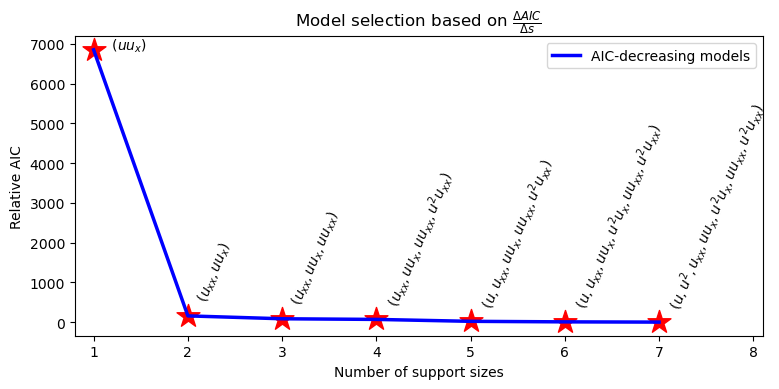

In [25]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(complexities, relative_decreasing_aics, color='blue', linewidth=2.5, label="AIC-decreasing models")
ax.scatter(complexities, relative_decreasing_aics, marker='*', c='red', s=300)
for com, name, rel_aic in zip(complexities, eff_feature_names, relative_decreasing_aics):
    rotation = (90+45)/2
    if com == 1: rotation = 0
    ax.annotate(f"    $({','.join(name)})$", (com, rel_aic), rotation=rotation)
plt.xlim(0.8,8.1)
plt.title(r"Model selection based on $\frac{\Delta AIC}{\Delta s}$")
plt.ylabel("Relative AIC")
plt.xlabel("Number of support sizes")
plt.legend()
plt.tight_layout()
# plt.savefig(join_path(FIGURE_EXPORT_PATH, "aic_model_selection.png"), dpi=300)
plt.show()

In [26]:
find_transition_V5(decreasing_aics, complexities, percent_ok=0.09)

2 improves 1
Percent improve: 0.10803697231852148
3 does not improve 2
Percent improve: 0.001055891859387946


2

In [27]:
### Robust PCA | 5e-2 ###
# (array([-67232.53198227, -75588.1584368 , -76240.48984011, -76260.73668138,
#         -76425.72108798, -76437.34969411, -76489.94051519, -76523.73245724]),
#  array([1, 2, 3, 4, 5, 6, 7, 8]),
#  [['u_{x}'],
#   ['u_{xx}', 'uu_{x}'],
#   ['u_{xx}', 'uu_{x}', 'u^2u_{x}'],
#   ['u_{xx}', 'uu_{x}', 'u^2u_{x}', 'u^2u_{xx}'],
#   ['u_{xx}', 'uu_{x}', 'u^2u_{x}', 'uu_{xx}', 'u^2u_{xx}'],
#   ['u^2', 'u_{xx}', 'uu_{x}', 'u^2u_{x}', 'uu_{xx}', 'u^2u_{xx}'],
#   ['u', 'u^2', 'u_{xx}', 'uu_{x}', 'u^2u_{x}', 'uu_{xx}', 'u^2u_{xx}'],
#   ['u',
#    'u^2',
#    'u_{x}',
#    'u_{xx}',
#    'uu_{x}',
#    'u^2u_{x}',
#    'uu_{xx}',
#    'u^2u_{xx}']])

### RDAE ###
# 5e-0
# (array([-61457.79563302, -67768.04270879, -67892.04820035, -67912.10229129,
#         -67929.64549213, -67937.40869858, -67945.9834522 ]),
#  array([1, 2, 3, 4, 5, 6, 7]),
#  [['uu_{x}'],
#   ['u_{xx}', 'uu_{x}'],
#   ['u_{xx}', 'uu_{x}', 'uu_{xx}'],
#   ['u', 'u_{xx}', 'uu_{x}', 'uu_{xx}'],
#   ['u', 'u_{xx}', 'uu_{x}', 'uu_{xx}', 'u^2u_{xx}'],
#   ['u', 'u_{xx}', 'uu_{x}', 'u^2u_{x}', 'uu_{xx}', 'u^2u_{xx}'],
#   ['u', 'u^2', 'u_{xx}', 'uu_{x}', 'u^2u_{x}', 'uu_{xx}', 'u^2u_{xx}']])

# 1e-0
# (array([-61470.53751784, -67403.7884947 , -67463.47315383, -67491.22503685,
#         -67524.31114049, -67541.30459472, -67577.12280888]),
#  array([1, 2, 3, 4, 5, 6, 7]),
#  [['uu_{x}'],
#   ['u_{xx}', 'uu_{x}'],
#   ['u_{xx}', 'uu_{x}', 'uu_{xx}'],
#   ['u_{xx}', 'uu_{x}', 'uu_{xx}', 'u^2u_{xx}'],
#   ['u', 'u_{xx}', 'uu_{x}', 'uu_{xx}', 'u^2u_{xx}'],
#   ['u', 'u_{xx}', 'uu_{x}', 'u^2u_{x}', 'uu_{xx}', 'u^2u_{xx}'],
#   ['u', 'u^2', 'u_{xx}', 'uu_{x}', 'u^2u_{x}', 'uu_{xx}', 'u^2u_{xx}']])

# 5e-1 (biggest drop)
# (array([-61942.58641101, -68634.67590443, -68707.14669999, -68723.3471394 ,
#         -68771.5720519 , -68784.91274736, -68791.13974807]),
#  array([1, 2, 3, 4, 5, 6, 7]),
#  [['uu_{x}'],
#   ['u_{xx}', 'uu_{x}'],
#   ['u_{xx}', 'uu_{x}', 'uu_{xx}'],
#   ['u_{xx}', 'uu_{x}', 'uu_{xx}', 'u^2u_{xx}'],
#   ['u', 'u_{xx}', 'uu_{x}', 'uu_{xx}', 'u^2u_{xx}'],
#   ['u', 'u_{xx}', 'uu_{x}', 'u^2u_{x}', 'uu_{xx}', 'u^2u_{xx}'],
#   ['u', 'u^2', 'u_{xx}', 'uu_{x}', 'u^2u_{x}', 'uu_{xx}', 'u^2u_{xx}']])

# 5e-2
# (array([-63319.57267493, -69422.77962975, -69521.1242639 , -69610.94610283,
#         -69632.39125379, -69759.73072006, -69759.86095886, -69766.15596996]),
#  array([1, 2, 3, 4, 5, 6, 7, 8]),
#  [['uu_{x}'],
#   ['u_{xx}', 'uu_{x}'],
#   ['u_{xx}', 'uu_{x}', 'u^2u_{x}'],
#   ['u_{xx}', 'uu_{x}', 'u^2u_{x}', 'uu_{xx}'],
#   ['u_{xx}', 'uu_{x}', 'u^2u_{x}', 'uu_{xx}', 'u^2u_{xx}'],
#   ['u', 'u^2', 'u_{xx}', 'uu_{x}', 'uu_{xx}', 'u^2u_{xx}'],
#   ['u', 'u^2', 'u_{x}', 'u_{xx}', 'uu_{x}', 'uu_{xx}', 'u^2u_{xx}'],
#   ['u',
#    'u^2',
#    'u_{x}',
#    'u_{xx}',
#    'uu_{x}',
#    'u^2u_{x}',
#    'uu_{xx}',
#    'u^2u_{xx}']])

# 5e-3
# (array([-62616.9439043 , -64382.30756858, -65732.60951777, -67060.56858316,
#         -67764.31672752, -67772.14160474, -67774.025401  , -67785.41418025]),
#  array([1, 2, 3, 4, 5, 6, 7, 8]),
#  [['uu_{x}'],
#   ['u^2', 'uu_{x}'],
#   ['u^2', 'uu_{x}', 'u^2u_{x}'],
#   ['u', 'u^2', 'uu_{x}', 'u^2u_{x}'],
#   ['u', 'u^2', 'u_{x}', 'uu_{x}', 'u^2u_{x}'],
#   ['u', 'u^2', 'u_{x}', 'u_{xx}', 'uu_{x}', 'u^2u_{x}'],
#   ['u', 'u^2', 'u_{x}', 'u_{xx}', 'uu_{x}', 'u^2u_{x}', 'uu_{xx}'],
#   ['u',
#    'u^2',
#    'u_{x}',
#    'u_{xx}',
#    'uu_{x}',
#    'u^2u_{x}',
#    'uu_{xx}',
#    'u^2u_{xx}']])

decreasing_aics, complexities, eff_feature_names

(array([-61942.58641101, -68634.67590443, -68707.14669999, -68723.3471394 ,
        -68771.5720519 , -68784.91274736, -68791.13974807]),
 array([1, 2, 3, 4, 5, 6, 7]),
 [['uu_{x}'],
  ['u_{xx}', 'uu_{x}'],
  ['u_{xx}', 'uu_{x}', 'uu_{xx}'],
  ['u_{xx}', 'uu_{x}', 'uu_{xx}', 'u^2u_{xx}'],
  ['u', 'u_{xx}', 'uu_{x}', 'uu_{xx}', 'u^2u_{xx}'],
  ['u', 'u_{xx}', 'uu_{x}', 'u^2u_{x}', 'uu_{xx}', 'u^2u_{xx}'],
  ['u', 'u^2', 'u_{xx}', 'uu_{x}', 'u^2u_{x}', 'uu_{xx}', 'u^2u_{xx}']])

In [28]:
X_pre = np.zeros(X_pre.shape)
y_pre = np.zeros(y_pre.shape)
n_times = 10
weak_coeffs = []
for _ in range(n_times):
    weak_pde_lib = ps.WeakPDELibrary(library_functions=[lambda x: x, lambda x: x * x], 
                                     function_names=[lambda x: x, lambda x: x + x], 
                                     derivative_order=diff_order, p=diff_order, 
                                     spatiotemporal_grid=XT, 
                                     include_bias=False, is_uniform=True, K=10000, 
                                     differentiation_method=differentiation_method, 
                                     differentiation_kwargs=differentiation_kwargs, 
                                     cache=True
                                    )
    kwargs = {'fit_intercept':False, 'copy_X':True, 'normalize_columns':False}
    # Apply moving horizon to un is an interesting idea.
    X_pre_sub, y_pre_sub, fns = ps_features(un, t, weak_pde_lib, kwargs)
    X_pre = X_pre + X_pre_sub
    y_pre = y_pre + y_pre_sub
    optimizer = L0BNB(max_nonzeros=2, lam=1e-3, is_normal=True, normalize_columns=False)
    n_ensemble_models = 50
    model = ps.SINDy(feature_library=weak_pde_lib, optimizer=optimizer, 
                     differentiation_method=KalmanDiff(alpha=kalpha, poly_deg=poly_deg, rpca_lambda=rpca_lambda, axis=0, is_uniform=True), 
                     cache=True,
                     feature_names=['u'])
    model.fit(np.expand_dims(un, -1), t=dt, ensemble=True, 
              library_ensemble=True, n_candidates_to_drop=1, n_models=n_ensemble_models)
    ols_model, eff_rhs_indices = model.validate_coef_list()[0]
    print(np.array([convert2latex(f) for i,f in enumerate(model.get_feature_names()) if i in eff_rhs_indices]))
    print(ols_model.params)
    # percent_coeff = evaluate_coefficients(ols_model.params)
    # print(percent_coeff)
    # if percent_coeff[0] > 100: break
    weak_coeffs.append(ols_model.params)
weak_coeffs = np.array(weak_coeffs)
avg_weak_coeff = np.mean(weak_coeffs, axis=0)
X_pre = X_pre/n_times
y_pre = y_pre/n_times

hasattr threshold in optimizer...
u_t = (0.095018 +0.000000i)u_11
    + (-1.006809 +0.000000i)uu_1
   
['u_{xx}' 'uu_{x}']
[ 0.09501766 -1.00680903]
hasattr threshold in optimizer...
u_t = (0.094381 +0.000000i)u_11
    + (-1.008122 +0.000000i)uu_1
   
['u_{xx}' 'uu_{x}']
[ 0.09438112 -1.00812189]
hasattr threshold in optimizer...
u_t = (0.095071 +0.000000i)u_11
    + (-1.001951 +0.000000i)uu_1
   
['u_{xx}' 'uu_{x}']
[ 0.09507057 -1.00195133]
hasattr threshold in optimizer...
u_t = (0.096951 +0.000000i)u_11
    + (-1.011645 +0.000000i)uu_1
   
['u_{xx}' 'uu_{x}']
[ 0.09695065 -1.01164504]
hasattr threshold in optimizer...
u_t = (0.094945 +0.000000i)u_11
    + (-1.008106 +0.000000i)uu_1
   
['u_{xx}' 'uu_{x}']
[ 0.09494541 -1.00810561]
hasattr threshold in optimizer...
u_t = (0.095566 +0.000000i)u_11
    + (-1.003437 +0.000000i)uu_1
   
['u_{xx}' 'uu_{x}']
[ 0.09556625 -1.00343747]
hasattr threshold in optimizer...
u_t = (0.096531 +0.000000i)u_11
    + (-1.015528 +0.000000i)uu_1
   
['u

In [29]:
# RDAE 5e-0: cv = 0.005062929348375081, 0.011023507990422338
# RDAE 1e-0: cv = 0.004408008789094885, 0.00910193468516509
# RDAE 5e-1: cv = 0.003467511174737858, 0.008040505161991068
# RDAE 5e-2: cv = 0.004305311364345706, 0.007809099375818377

cv_abs = (weak_coeffs.std(axis=0)/np.abs(weak_coeffs.mean(axis=0))).mean()
cv = (weak_coeffs.std(axis=0)/weak_coeffs.mean(axis=0)).mean()
cv, cv_abs

(0.003467511174737858, 0.008040505161991068)

In [30]:
# 50 percent noise
# Robust PCA: (14.745720655392669, 6.347415766367691)
# RDAE failed...

# 40 percent noise
# Robust PCA: (14.818002368919029, 7.899799685479938)
# RDAE 5e-0: (2.9505659028666087, 1.8024006266427972)
# RDAE 1e-0: (3.2008235132427463, 2.56690175990938)
# RDAE 5e-1: (2.469185388081714, 1.7166311808760781)
# RDAE 5e-2: (6.015975755333656, 5.859365864415776)
# RDAE 5e-3: Failed

evaluate_coefficients(avg_weak_coeff)

(2.469185388081714, 1.7166311808760781)

In [31]:
def percent_coeff(pred, ground):
    return 100*np.abs(pred-ground)/np.abs(ground)
print(avg_weak_coeff)
errs = percent_coeff(avg_weak_coeff, np.array([0.1, -1]))
errs.mean(), errs.std()

[ 0.09581418 -1.00752554]


(2.469185388081714, 1.7166311808760781)

In [32]:
# best_subsets = [(4,), (3, 4), (3, 4, 6), (0, 3, 4, 6), (0, 3, 4, 6, 7), (0, 1, 3, 4, 6, 7), (0, 1, 2, 3, 4, 6, 7), (0, 1, 2, 3, 4, 5, 6, 7)]
# tmp = np.zeros((len(best_subsets), X_pre.shape[-1]))
# for i in range(len(best_subsets)):
#     tmp[i:i+1, :][0, best_subsets[i]] = 1.0
# best_subsets = tmp.astype(np.float32)
# del tmp

# pms_data = {nameof(X_pre): X_pre.astype(np.float32), 
#             nameof(y_pre): y_pre.astype(np.float32), 
#             nameof(best_subsets): best_subsets.astype(np.float32)}
# h5file(file_path="../PMS_data/burgers_pms.h5", cdict=pms_data, mode='w')

In [33]:
X_pre, best_subsets, y_pre = h5file(file_path="../PMS_data/burgers_pms.h5", mode='r', return_dict=False)

['X_pre', 'best_subsets', 'y_pre']


In [34]:
basic_vars = {'u'}
encoded_feature_names = []
for feature in model.get_feature_names():
    out_feature = []
    last_index = -1
    for i, c in enumerate(feature):
        if i+1 < len(feature) and feature[i+1] in basic_vars:
            last_index = i
            out_feature.append(c+'*')
    out_feature.append(feature[last_index+1:])
    encoded_feature_names.append(''.join(out_feature))
encoded_feature_names = np.array(encoded_feature_names)
encoded_feature_names

array(['u', 'u*u', 'u_1', 'u_11', 'u*u_1', 'u*u*u_1', 'u*u_11',
       'u*u*u_11'], dtype='<U8')

In [35]:
'+'.join(np.array(encoded_feature_names)[[2,3]])

'u_1+u_11'

In [36]:
for com in sorted(st.track.keys()):
    indices, _ = st.track[com]
    expr = '+'.join(encoded_feature_names[list(indices)])
    print(expr)
    print('----------')

u*u_1
----------
u_11+u*u_1
----------
u_11+u*u_1+u*u_11
----------
u_11+u*u_1+u*u_11+u*u*u_11
----------
u+u_11+u*u_1+u*u_11+u*u*u_11
----------
u+u_11+u*u_1+u*u*u_1+u*u_11+u*u*u_11
----------
u+u*u+u_11+u*u_1+u*u*u_1+u*u_11+u*u*u_11
----------
u+u*u+u_1+u_11+u*u_1+u*u*u_1+u*u_11+u*u*u_11
----------


In [37]:
indices, _ = st.track[2]
sympy_expr, basic_vars = math_eval('+'.join(encoded_feature_names[list(indices)]))
sympy_expr, basic_vars

(<function _lambdifygenerated(u, u_1, u_11)>, ['u', 'u_1', 'u_11'])

In [38]:
# tmp = X_pre[:, [model.get_feature_names().index(e) for e in basic_vars]]
# tmp = [aa[:, i:i+1].flatten() for i in range(aa.shape[-1])]
# tmp
sympy_expr_kwargs = dict(zip(basic_vars, 
                             list(X_pre[:, [model.get_feature_names().index(e) for e in basic_vars]].T)))
print(sympy_expr_kwargs)
sympy_expr(**sympy_expr_kwargs)

{'u': array([0.04970421, 0.05950946, 0.03799988, ..., 0.04010152, 0.06877201,
       0.04658481], dtype=float32), 'u_1': array([-0.02309883,  0.02021311,  0.0148508 , ..., -0.00020373,
        0.01919393, -0.01195044], dtype=float32), 'u_11': array([-0.01942476, -0.00494556,  0.00399714, ...,  0.04948348,
       -0.01323579,  0.06216776], dtype=float32)}


array([-0.02057287, -0.00374269,  0.00456147, ...,  0.04947531,
       -0.01191578,  0.06161105], dtype=float32)

In [39]:
mod, basic_vars = math_eval('+'.join(encoded_feature_names[list(indices)]), return_torch=True)

In [40]:
torch.tensor(sympy_expr_kwargs['u']).float()

tensor([0.0497, 0.0595, 0.0380,  ..., 0.0401, 0.0688, 0.0466])

In [41]:
# sympytorch.SymPyModule -> implement แยกตามเครื่องหมาย +
torch_vars = [symbols(var) for var in basic_vars]
out = mod(u=torch.tensor(sympy_expr_kwargs['u']).float(), 
          u_1=torch.tensor(sympy_expr_kwargs['u_1']).float(), 
         u_11=torch.tensor(sympy_expr_kwargs['u_11']).float())  # out has shape (3, 2)
# out[:,0]
out

tensor([[-0.0206],
        [-0.0037],
        [ 0.0046],
        ...,
        [ 0.0495],
        [-0.0119],
        [ 0.0616]])

In [42]:
np.allclose(sympy_expr(**sympy_expr_kwargs), out[:,0].detach().numpy())

True

In [43]:
mod, basic_vars = math_eval("u_11+u*u_1", 
                            return_torch=True, split_by_addition=True)
x_ = torch.rand(3)
mod(u_11=x_, u=x_, u_1=x_)

tensor([[3.4913e-01, 1.2189e-01],
        [2.0430e-02, 4.1740e-04],
        [9.3016e-01, 8.6519e-01]])

In [44]:
nameof(x_), x_, x_**2

('x_',
 tensor([0.3491, 0.0204, 0.9302]),
 tensor([1.2189e-01, 4.1740e-04, 8.6519e-01]))

In [45]:
class PhysicalConstraintCalculator(torch.nn.Module):
    def __init__(self, symbolic_module, basic_vars, init_coefficients=None, learnable_coefficients=False):
        super(PhysicalConstraintCalculator, self).__init__()
        self.symbolic_module = symbolic_module
        self.basic_vars = basic_vars
        
        self.coefficients = init_coefficients
        self.learnable_coefficients = learnable_coefficients

        if self.coefficients is None:
            self.coefficients = torch.ones(len(symbolic_module.sympy())).float().requires_grad_(self.learnable_coefficients)
        else:
            self.coefficients = torch.tensor(data=self.coefficients).float().requires_grad_(self.learnable_coefficients)
            
        if self.learnable_coefficients: print("Learnable coefficients:", self.coefficients)
        else: print("NOT learnable coefficients:", self.coefficients)
        print(symbolic_module.sympy())
        print("Basic variables:", self.basic_vars)
            
    def forward(self, input_dict):
        return self.symbolic_module(**input_dict)*self.coefficients

In [46]:
class TorchMLP(nn.Module):
    def __init__(self, dimensions, bias=True, activation_function=nn.Tanh(), bn=None, dropout=None):
        super(TorchMLP, self).__init__()
        # setup ModuleList
        self.model  = nn.ModuleList()
        for i in range(len(dimensions)-1):
            self.model.append(nn.Linear(dimensions[i], dimensions[i+1], bias=bias))
            if bn is not None and i!=len(dimensions)-2:
                self.model.append(bn(dimensions[i+1]))
                if dropout is not None:
                    self.model.append(dropout)
            if i==len(dimensions)-2: break
            self.model.append(activation_function)
        # weight init
        self.model.apply(self.xavier_init)

    def xavier_init(self, m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.0)

    def forward(self, x):
        for i, l in enumerate(self.model): 
            x = l(x)
        return x

In [47]:
rng = default_rng()
sampled_indices_x = rng.choice(len(x), size=int(len(x)//(5)), replace=False)
sampled_indices_t = rng.choice(len(t), size=int(len(t)//(5)), replace=False)

In [48]:
X_train = np.hstack((X[sampled_indices_t, :][:, sampled_indices_x].flatten()[:,None], 
                     T[sampled_indices_t, :][:, sampled_indices_x].flatten()[:,None]))
y_train = un.T[sampled_indices_t, :][:, sampled_indices_x].flatten()[:,None]
lb = torch.tensor(X_train.min(axis=0)).float().requires_grad_(False)
ub = torch.tensor(X_train.max(axis=0)).float().requires_grad_(False)

In [49]:
# Converting to tensors
X_train = torch.tensor(X_train).float().requires_grad_(True)
y_train = torch.tensor(y_train).float().requires_grad_(False)
X_train.shape, y_train.shape

(torch.Size([1020, 2]), torch.Size([1020, 1]))

In [50]:
com = 2; com = max(com, 1)
init_coefficients = np.linalg.lstsq(X_pre[:, np.where(best_subsets[com-1]>0)[0]], 
                                    y_pre)[0].flatten()
init_coefficients

array([ 0.09517879, -1.0106909 ], dtype=float32)

In [51]:
physics_calculator = PhysicalConstraintCalculator(symbolic_module=mod, 
                                                  basic_vars=basic_vars, 
                                                  init_coefficients=init_coefficients)

NOT learnable coefficients: tensor([ 0.0952, -1.0107])
[u_11, u*u_1]
Basic variables: ['u', 'u_1', 'u_11']


In [52]:
from torch.autograd import grad

class PINN(nn.Module):
    def __init__(self, solver, physics_calculator, lb, ub):
        super(PINN, self).__init__()
        self.solver = solver
        self.physics_calculator = physics_calculator
        self.lb = lb
        self.ub = ub
        
    def forward(self, x, t):
        return self.solver(self.input_normalize(torch.cat([x, t],  dim=-1)))
    
    def loss(self, x, t, y_input, print_losses=False):
        u = self.forward(x, t)
        
        # PDE Loss calculation
        u_t = self.gradients(u, t)[0]
        u_1 = self.gradients(u, x)[0]
        u_11 = self.gradients(u_1, x)[0]
        physics = self.physics_calculator({nameof(u):u, 
                                        nameof(u_1):u_1, 
                                        nameof(u_11):u_11}).sum(axis=-1)
        
        l_eq = F.mse_loss(u_t, physics, reduction='mean')
        mse = F.mse_loss(u, y_input, reduction='mean')
        
        return l_eq+mse
    
    def gradients(self, func, x):
        return grad(func, x, create_graph=True, retain_graph=True, grad_outputs=torch.ones(func.shape))

    def input_normalize(self, inp):
        return -1.0+2.0*(inp-self.lb)/(self.ub-self.lb)

In [53]:
solver = TorchMLP([2,50,50,50,50,1], bn=None, activation_function=nn.Tanh())

In [54]:
pinn = PINN(solver, physics_calculator, lb, ub)
pinn.loss(X_train[:,0:1][:10, :], X_train[:,1:2][:10, :], y_train[:10])

tensor(0.0849, grad_fn=<AddBackward0>)

#### For training DeepONets

In [55]:
# data['un'] = un_copy+0.0j
# data['denoised_un'] = un+0.0j
# data['discovered_coefficients'] = ols_model.params
# data['feature_names'] = np.array([convert2latex(f) for i,f in enumerate(model.get_feature_names()) if i in eff_rhs_indices])
# sio.savemat("../Datasets/noisy_burgers.mat", data)

# data['un'] = un_copy+0.0j
# sio.savemat("../RDAE_data/noisy40_burgers.mat", data)

#### Physics-informed model selection.... (2 options)
    - Fixed coefficients + learned diffivative values (by autodiff)
    - Fixed polynomial candidate values (following feature_names: ['u', 'uu', 'u_1', 'u_11', 'uu_1', 'uuu_1', 'uu_11', 'uuu_11']) + learned coefficients

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

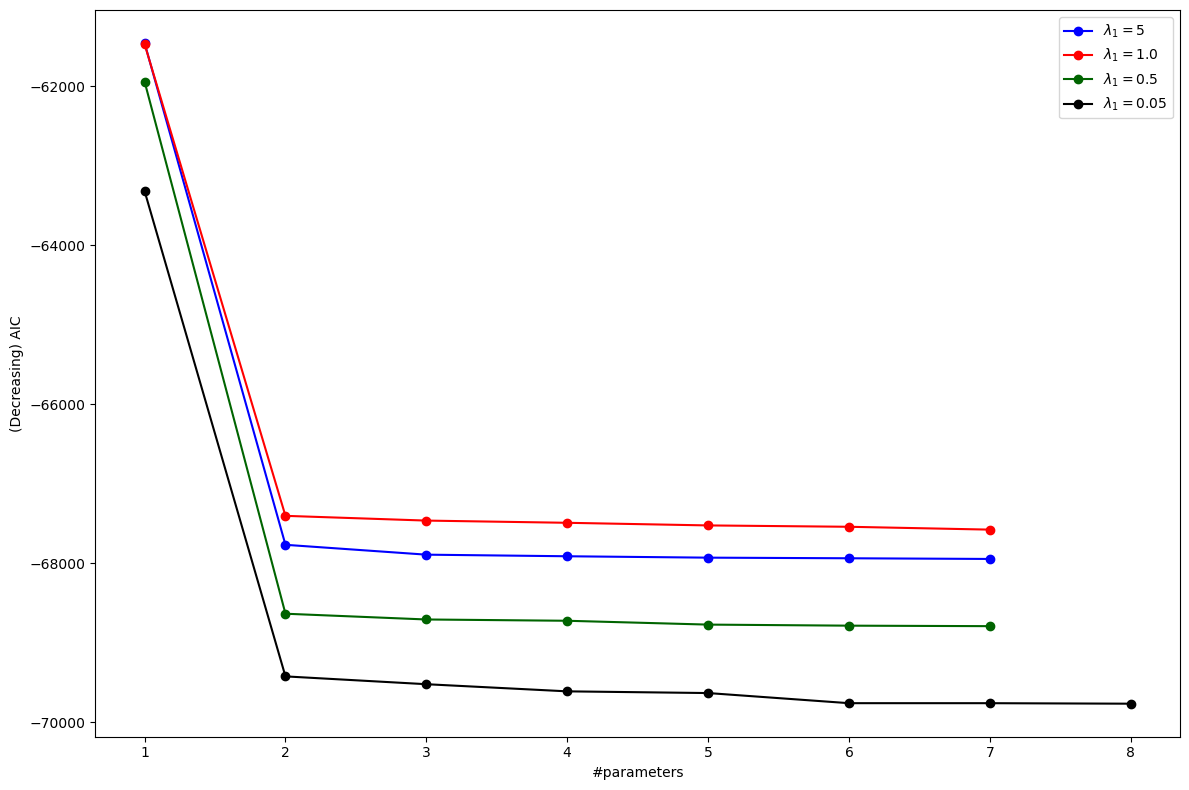

In [57]:
ic1 = np.array([-61457.79563302, -67768.04270879, -67892.04820035, -67912.10229129, -67929.64549213, -67937.40869858, -67945.9834522 ])
coms1 = np.array([1, 2, 3, 4, 5, 6, 7])
ic2 = np.array([-61942.58641101, -68634.67590443, -68707.14669999, -68723.3471394 , -68771.5720519 , -68784.91274736, -68791.13974807])
coms2 = np.array([1, 2, 3, 4, 5, 6, 7])
ic3 = np.array([-61470.53751784, -67403.7884947 , -67463.47315383, -67491.22503685, -67524.31114049, -67541.30459472, -67577.12280888])
coms3 = np.array([1, 2, 3, 4, 5, 6, 7])
ic4 = np.array([-63319.57267493, -69422.77962975, -69521.1242639 , -69610.94610283, -69632.39125379, -69759.73072006, -69759.86095886, -69766.15596996])
coms4 = np.array([1, 2, 3, 4, 5, 6, 7, 8])

plt.plot(coms1, ic1, '-o', label='$\lambda_{1}=5$', color='blue')
plt.plot(coms3, ic3, '-o', label='$\lambda_{1}=1.0$', color='red')
plt.plot(coms2, ic2, '-o', label='$\lambda_{1}=0.5$', color='darkgreen')
plt.plot(coms4, ic4, '-o', label='$\lambda_{1}=0.05$', color='black')
plt.ylabel("(Decreasing) AIC")
plt.xlabel("#parameters")
plt.legend()
plt.tight_layout()
# plt.savefig('ffff1.pdf')
plt.show()

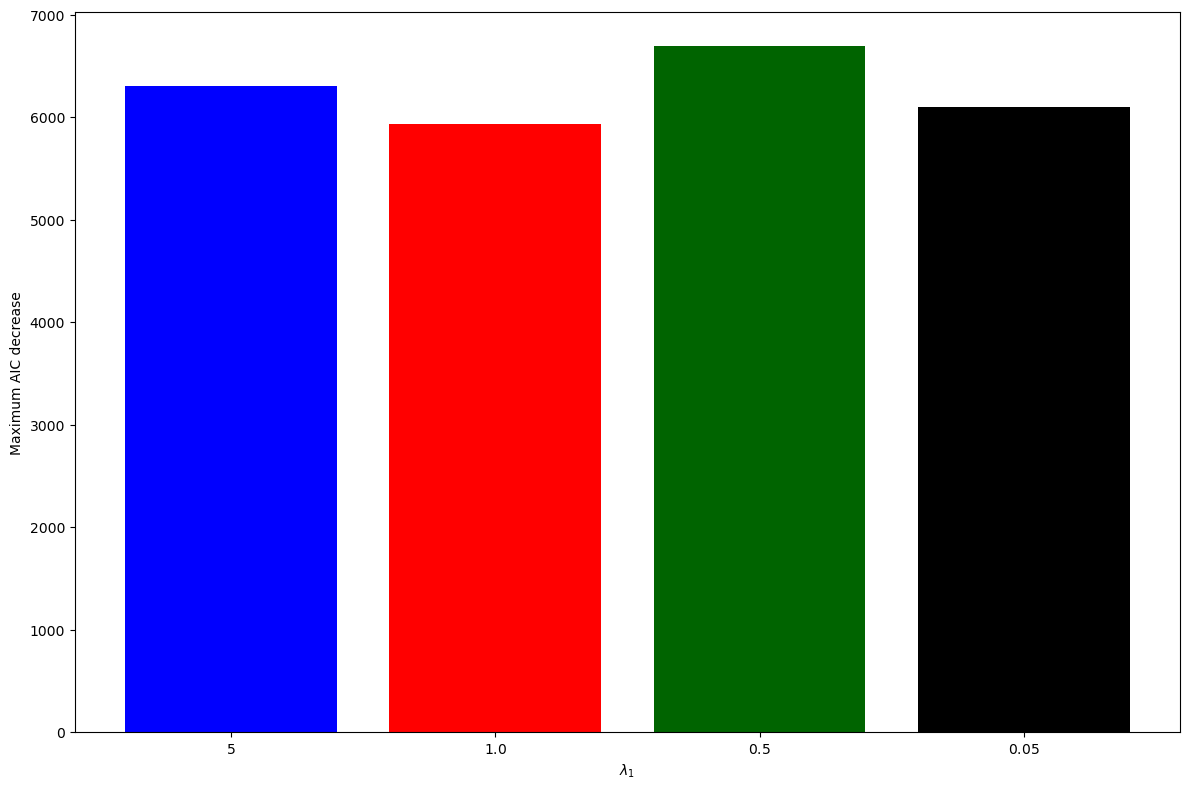

In [58]:
xs = ['$5$', '$1.0$', '$0.5$', '$0.05$']
ys = [ic1[0]-ic1[1], ic3[0]-ic3[1], ic2[0]-ic2[1], ic4[0]-ic4[1]]
colors = ['blue', 'red', 'darkgreen', 'black']
for i in range(len(xs)):
    plt.bar(xs[i], ys[i], color=colors[i])
plt.ylabel('Maximum AIC decrease')
plt.xlabel('$\lambda_{1}$')
plt.tight_layout()
# plt.savefig('ffff2.pdf')
plt.show()

In [59]:
# RDAE 5e-0: (2.9505659028666087, 1.8024006266427972) -> 1
# RDAE 1e-1: (3.2008235132427463, 2.56690175990938) -> 2
# RDAE 5e-1: (2.469185388081714, 1.7166311808760781) -> 0
# RDAE 5e-2: (6.015975755333656, 5.859365864415776) -> 3

In [60]:
# cv_abs/(max_diff_bic) -> Experiments on more PDEs are required.

In [61]:
ics = np.array([ic1[0]-ic1[1], ic3[0]-ic3[1], ic2[0]-ic2[1], ic4[0]-ic4[1]])
cvs = np.array([0.005062929348375081, 0.004408008789094885, 0.003467511174737858, 0.004305311364345706])
cvs_abs = np.array([0.011023507990422338, 0.00910193468516509, 0.008040505161991068, 0.007809099375818377])

In [62]:
cvs/ics

array([8.02334566e-07, 7.42933142e-07, 5.18150748e-07, 7.05417889e-07])

In [63]:
cvs_abs/ics

array([1.74692177e-06, 1.53405523e-06, 1.20149397e-06, 1.27950755e-06])